In [98]:
import time
import base64
import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.asymmetric import padding
from google.colab import userdata


In [99]:
def kalshi_headers(method: str, path: str) -> dict:
    api_key = userdata.get("KALSHI_API_KEY")
    private_key_pem = userdata.get("KALSHI_PRIVATE_KEY")

    timestamp = str(int(time.time() * 1000))
    message = f"{timestamp}{method}{path}"

    private_key = serialization.load_pem_private_key(
        private_key_pem.encode(), password=None
    )

    signature = base64.b64encode(
        private_key.sign(
            message.encode(),
            padding.PSS(
                mgf=padding.MGF1(hashes.SHA256()),
                salt_length=padding.PSS.DIGEST_LENGTH,
            ),
            hashes.SHA256(),
        )
    ).decode()

    return {
        "KALSHI-ACCESS-KEY": api_key,
        "KALSHI-ACCESS-SIGNATURE": signature,
        "KALSHI-ACCESS-TIMESTAMP": timestamp,
    }


In [100]:
def fetch_belief_trace(
    series_ticker: str,
    market_ticker: str,
    start_ts: int,
    end_ts: int,
    interval_minutes: int = 60,
) -> pd.DataFrame:
    """
    Fetch historical belief trace for a Kalshi market.
    interval_minutes must be one of: 1, 5, 15, 60, 1440
    """

    path = (
        f"/trade-api/v2/series/{series_ticker}"
        f"/markets/{market_ticker}/candlesticks"
    )

    url = (
        f"https://api.elections.kalshi.com{path}"
        f"?start_ts={start_ts}"
        f"&end_ts={end_ts}"
        f"&period_interval={interval_minutes}"
    )

    headers = kalshi_headers("GET", path)
    resp = requests.get(url, headers=headers)

    if resp.status_code != 200:
        raise RuntimeError(resp.text)

    candles = resp.json().get("candlesticks", [])

    if not candles:
        raise ValueError(
            f"No candlesticks returned for {market_ticker} "
            f"in window {start_ts} → {end_ts}"
        )

    df = pd.DataFrame([{
        "time": datetime.datetime.fromtimestamp(c["end_period_ts"]),
        "price": c["price"]["close_dollars"] if c["price"]["close"] else None,
        "volume": c["volume"],
        "open_interest": c["open_interest"],
    } for c in candles])

    return df.sort_values("time").reset_index(drop=True)


In [101]:
def save_belief_trace(df: pd.DataFrame, name: str):
    path = Path(f"/content/{name}.csv")
    df.to_csv(path, index=False)
    print(f"Saved belief trace → {path}")


In [102]:
def list_all_markets(series_ticker: str):
    url = "https://api.elections.kalshi.com/trade-api/v2/markets"
    params = {
        "series_ticker": series_ticker
    }

    resp = requests.get(url, params=params)
    if resp.status_code != 200:
        raise RuntimeError(resp.text)

    return resp.json().get("markets", [])


In [103]:
markets = list_all_markets("KXNEWPOPEROUNDS")

for m in markets:
    print(
        f"{m['ticker']} | {m['title']} | "
        f"Status: {m['status']} | "
        f"Resolved: {m.get('close_time')}"
    )


KXNEWPOPEROUNDS-25-9.5 | How many rounds will it take to elect the new Pope? | Status: finalized | Resolved: 2025-05-08T17:25:57.216706Z
KXNEWPOPEROUNDS-25-7.5 | How many rounds will it take to elect the new Pope? | Status: finalized | Resolved: 2025-05-08T17:25:57.216706Z
KXNEWPOPEROUNDS-25-5.5 | How many rounds will it take to elect the new Pope? | Status: finalized | Resolved: 2025-05-08T17:25:57.216706Z
KXNEWPOPEROUNDS-25-3.5 | How many rounds will it take to elect the new Pope? | Status: finalized | Resolved: 2025-05-08T17:25:57.216706Z
KXNEWPOPEROUNDS-25-3 | How many rounds will it take to elect the new Pope? | Status: finalized | Resolved: 2025-05-08T17:25:57.216706Z
KXNEWPOPEROUNDS-25-19 | How many rounds will it take to elect the new Pope? | Status: finalized | Resolved: 2025-05-08T17:25:57.216706Z
KXNEWPOPEROUNDS-25-17.0 | How many rounds will it take to elect the new Pope? | Status: finalized | Resolved: 2025-05-08T17:25:57.216706Z
KXNEWPOPEROUNDS-25-12.5 | How many rounds w

In [104]:
# Resolution time
end_ts = int(datetime.datetime(2025, 5, 8).timestamp())

# Look 60 days before resolution
start_ts = end_ts - 60 * 24 * 60 * 60

df = fetch_belief_trace(
    series_ticker="KXNEWPOPEROUNDS",
    market_ticker="KXNEWPOPEROUNDS-25-5.5",
    start_ts=start_ts,
    end_ts=end_ts,
    interval_minutes=60   # 1 hour
)

save_belief_trace(
    df,
    "belief_trace__kalshi__pope"
)


Saved belief trace → /content/belief_trace__kalshi__pope.csv


In [105]:
# Load belief trace
df = pd.read_csv(
    "/content/belief_trace__kalshi__pope.csv",
    parse_dates=["time"]
)

df = df.sort_values("time").reset_index(drop=True)
df.head()


,time,price,volume,open_interest
0,2025-04-25 15:00:00,0.38,157,157
1,2025-04-25 16:00:00,0.37,505,662
2,2025-04-25 17:00:00,NaN,0,662
3,2025-04-25 18:00:00,0.38,2,662
4,2025-04-25 19:00:00,NaN,0,662


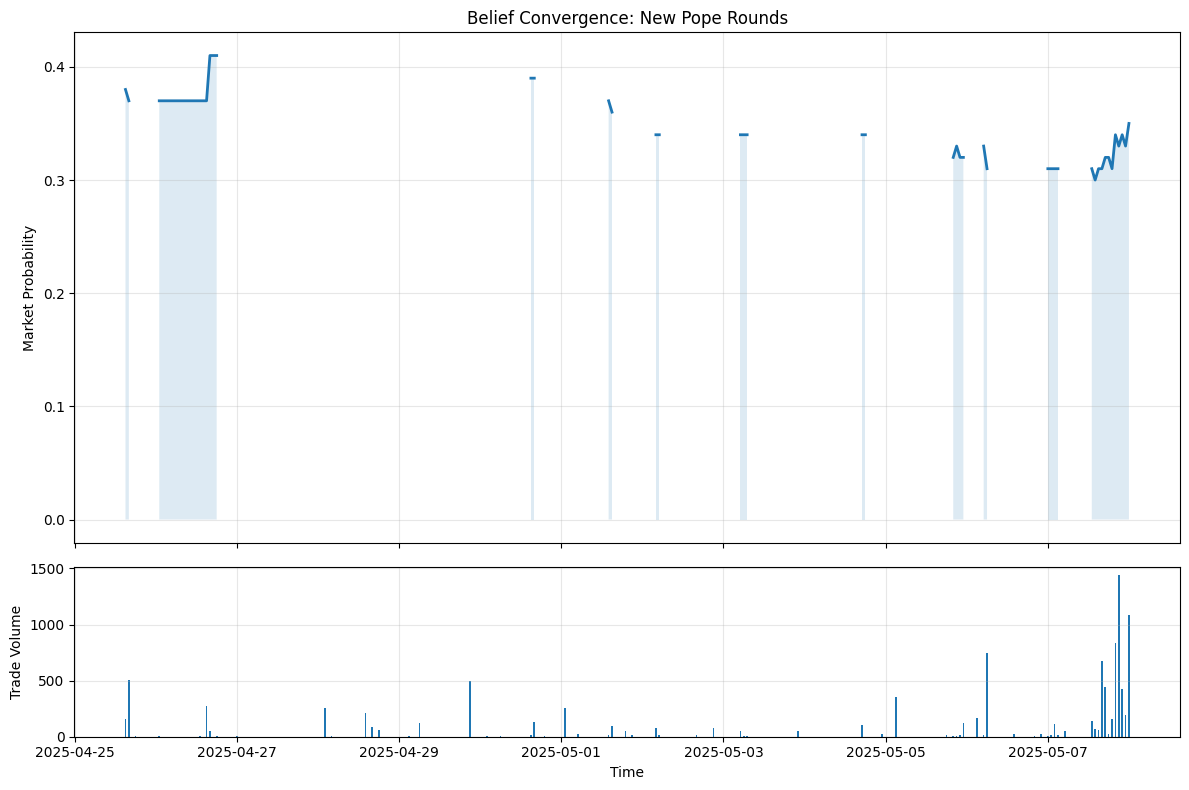

In [106]:
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(12, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

# --- Belief (probability) ---
ax1.plot(
    df["time"],
    df["price"],
    linewidth=2
)
ax1.fill_between(
    df["time"],
    df["price"],
    alpha=0.15
)
ax1.set_ylabel("Market Probability")
ax1.set_title("Belief Convergence: New Pope Rounds")
ax1.grid(alpha=0.3)

# --- Activity (volume) ---
ax2.bar(
    df["time"],
    df["volume"],
    width=0.02
)
ax2.set_ylabel("Trade Volume")
ax2.set_xlabel("Time")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [108]:
df["belief_change"] = df["price"].diff().abs()

belief_volatility = df["belief_change"].mean()
belief_max_jump = df["belief_change"].max()

belief_volatility, belief_max_jump


(np.float64(0.007586206896551727), 0.03999999999999998)

In [109]:
inactive_fraction = (df["volume"] == 0).mean()
inactive_fraction


np.float64(0.7058823529411765)

In [110]:
collapse_threshold = 0.95

collapsed = df[df["price"] >= collapse_threshold]

if not collapsed.empty:
    collapse_time = collapsed.iloc[0]["time"]
else:
    collapse_time = None

collapse_time


In [111]:
summary = {
    "num_observations": len(df),
    "belief_volatility_mean": belief_volatility,
    "belief_max_jump": belief_max_jump,
    "inactive_fraction": inactive_fraction,
    "collapse_time": collapse_time,
}

pd.Series(summary)


,0
num_observations,238.000000
belief_volatility_mean,0.007586
belief_max_jump,0.040000
inactive_fraction,0.705882
collapse_time,NaN
